# Fraud
## Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards or doing money laundry.

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

## Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.


You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.


You only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).


These are the tasks you are asked to do:


- For each user, determine their country based on the IP address


- Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model


- Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?


- Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Data

In [32]:
import pandas as pd
import numpy as np
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)
  
#read from google drive
data=pandas.read_csv("./data/Fraud/Fraud_Data.csv")
#fix ip address
data['ip_address']=round(data['ip_address'])
  
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


- user_id : Id of the user. Unique by user

- signup_time : the time when the user created her account (GMT time)

- purchase_time : the time when the user bought the item (GMT time)

- purchase_value : the cost of the item purchased (USD)

- device_id : the device id. You can assume that it is unique by device. I.e., same device ID means that the same physical device was used for the transaction

- source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser)

- browser : the browser used by the user

- sex : user sex: Male/Female

- age : user age

- ip_address : user numeric ip address

- class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0)

And the second dataset can be used to get user country based on their Ip address. For each country, it gives a range. If the numeric ip address falls within that range, then the ip address belongs to the corresponding country:

In [33]:
#Read from google drive
ip_addresses=pd.read_csv("https://drive.google.com/uc?export=download&id=1rzr6aVDHlSuKFZHOvE6wJI-yzv7ICYuY")
  
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## First Question Solution
For each user, determine their country based on the IP address


In [34]:
#Let's add the country to the original data set by using the ip address
data_country = [None] * data.shape[0]

for i in range(data.shape[0]):
    tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                       (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])]['country'].values
    if (len(tmp)==1) :
        data_country[i] = tmp

In [35]:
data['country'] = data_country
data['country'] = data['country'].str.get(0)

In [36]:
print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


## Second Question Solution

Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model

Before jumping into building a model, think about whether you can create new powerful variables. This is called feature engineering and it is the most important step in machine learning. However, feature engineering is quite time consuming. In a take-home you should just give an idea of how you would do it and emphasize that with more time you would go deeper into it.


A few obvious variables that can be created here could be:


- Time difference between sign-up time and purchase time


- If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)


- Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

In [39]:
#make them dates
data["signup_time"]   = pd.to_datetime(data["signup_time"])
data["purchase_time"] = pd.to_datetime(data["purchase_time"])
#and take the difference
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()

In [40]:
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
  
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)
  
#replace None in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)

In [47]:
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'other')
data_rf['country'] = data_rf['country'].replace(x)

#make dummy
data_rf = pd.get_dummies(data_rf, drop_first=True)

In [49]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)

# build the model
rf = RandomForestClassifier(n_estimators=100,max_features=3,oob_score=True)
rf.fit(train.drop('class',axis=1),train['class'])
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9564938385489257 
 OOB Confusion Matrix 
        0     1
0  90371    74
1   4265  5023



The confusion matrix looks good. We are not overfitting given that OOB and test results are very similar. Class 0 error is almost zero, and we are doing surprisignly well also with regards to class 1 error, which is pretty rare.


However, since the challenge asks about false positives and false negatives, this usually implies building the ROC and look for possible cut-off points. And in general, especially when dealing with fraud, you should always do the cut-off analysis. There is no reason why the default 0.5 value has to be the best one.

In [57]:
#We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))


True


Cool. So they are the same! However, is really 0.5 the best possible cut-off? It really depends on what we are optimizing for (accuracy? true positive? true negative? etc.)

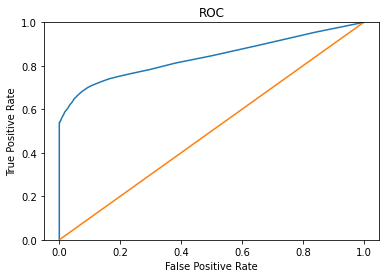

In [63]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate near 0.6 and false positive rate basically zero (this was similar to the default random forest output). However, if we care about maximizing true positive rate, we will have to significantly decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).


If we want to be a bit more accurate, we can use the approach of maximizing true positive rate - false positive rate, this is the same as maximizing (1-class1_error) - class0_error as we saw in the unbalanced data section.

In [64]:
#For consistency with R, we will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pandas.DataFrame({'cutoff':pd.Series(thresholds),
                               'class0_error':pd.Series(fpr),
                               'class1_error': 1 - pd.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
58    0.14       0.07333      0.319145       0.607526



The best value is in the area near 65% true positive rate (specifically 1-0.32 = 0.68) and very low false positive rate (~7%). You can find the corresponding point on the ROC curve.


Regarding insights, it is the same as in the previous projects. So we won’t do it. At this point, we know the random forest is predicting well, so it simply boils down to building the partial dependence plots and explaining them.



## Final Question



The last question is very important:


- Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

You now have a model that assigns to each user a probability of committing a fraud. And, despite our model doing pretty well, no model is perfect. So you will have some misclassifications. It is crucial now to think about building a product that minimizes the impact (aka cost) of those misclassifications. A very commonly used approach is to think about creating different experiences based on the model score. For instance:


1. If predicted fraud probability < X, the user has the normal experience (the high majority of users should fall here)


2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like phone number verifications via a code sent by SMS or asking to log in via social network accounts


3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his activity has been put on hold, send this user info to someone who reviews it manually, and finally either block the user or decide it is not a fraud so the session is resumed


This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).